In [5]:
## prepare .dates.txt and .traits.txt files
import imp
from StringIO import StringIO
from zipfile import ZipFile

bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')

zipfile = ZipFile('./../data/phylo/sequences.zip')

fasta_path='sequences/MERS_CoV_274_CDS.fna'
seqs={}
ds={}
dates=open('./../data/phylo/MERS_CoV_274_CDS.dates.txt','w')
traits=open('./../data/phylo/MERS_CoV_274_CDS.traits.txt','w')

for line in zipfile.open(fasta_path).readlines():
    l=line.strip('\n')
    if '>' in l:
        n=l[1:]
        d=l.split('|')[-1]
        t=l.split('|')[2][0]
        if d.count('-')==1:
            d=d+'-15'
            
        ds[l[1:]]=bt.decimalDate(d)
        print>>dates,'%s\t%s'%(l[1:],ds[l[1:]])
        print>>traits,'%s\t%s'%(l[1:],t)
    else:
        seqs[n]=l
        
dates.close()
traits.close()

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

from StringIO import StringIO
from zipfile import ZipFile

from IPython.display import HTML
import re
import datetime as dt
import numpy as np
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

zipfile = ZipFile('./../data/phylo/structured-coalescent.zip')
tree12=bt.loadNexus(zipfile.open('MERS_274_sCoal.combinedTyped.mcc.tree').readlines())

zipfile = ZipFile('./../data/phylo/structured-coalescent-2fragments.zip')
frag1=bt.loadNexus(zipfile.open('MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree').readlines())
frag2=bt.loadNexus(zipfile.open('MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree').readlines())
#print zipfile.namelist()

clist=[(0.0,mpl.cm.Vega10(0)),
       (0.5,'grey'),
       (1.0,mpl.cm.Vega10(1))]

host_cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)

path='<iframe style="border: 0; width: 400px; height: 274px;" src="https://bandcamp.com/EmbeddedPlayer/album=527596905/size=large/bgcol=ffffff/linkcol=e99708/artwork=small/transparent=true/" seamless><a href="http://vilkduja.bandcamp.com/album/dabartis-the-present-split-w-ob-rr">Dabartis (The Present) - split w/ OBSRR by Vilkduja</a></iframe>'

HTML(path)

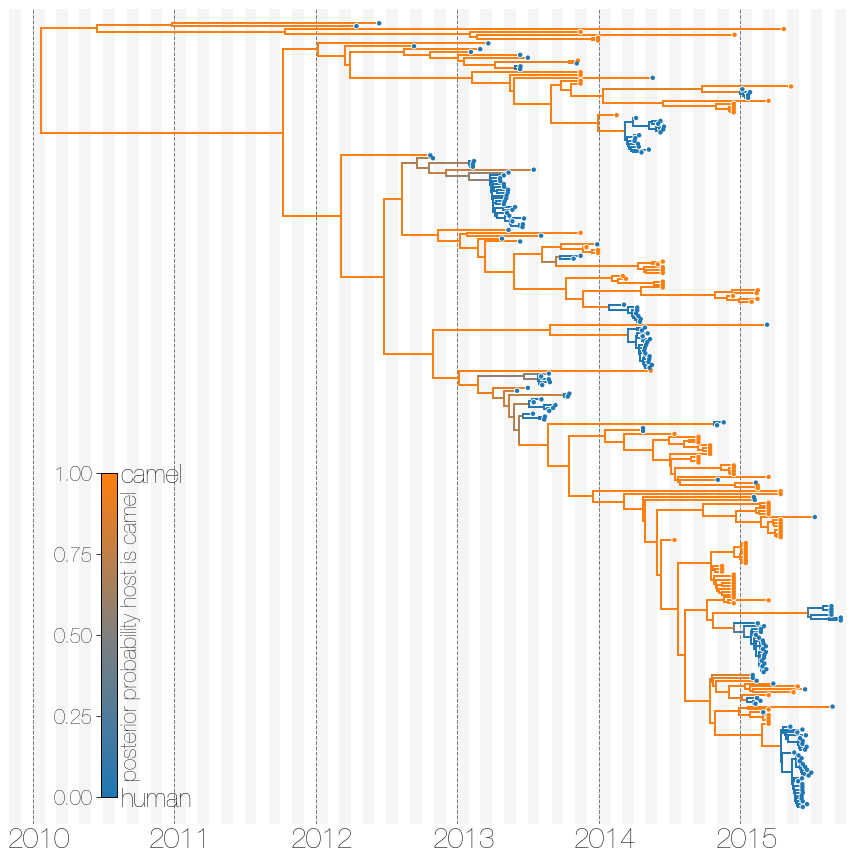

In [2]:
fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2009,2016) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=28,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2000,2020)]

#genomeTree=bt.loadNexus(subtree_root+'MERS_307.HinfectC.combined.mcc.tree')
order=[k.name for k in tree12.traverse_tree()]

skip=0
branchWidth=2
types=['h','c']

for k in tree12.Objects:
    c='k'
    if 'c' in k.traits['type.set']:
        hidx=k.traits['type.set'].index('c')
        c=host_cmap(k.traits['type.set.prob'][hidx])
    else:
        c=host_cmap(0.0)

    z=1
    if k.traits['type']=='h':
        z=2

    x=k.absoluteTime
    y=k.y

    xp=k.parent.absoluteTime
    if xp==0:
        xp=x
    
    if k.branchType=='leaf':
        ax.scatter(x,y,s=20,facecolor=c,edgecolor='none',zorder=4)
        ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
    else:
        yl=k.children[0].y+skip
        yr=k.children[-1].y+skip
        ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)
        
    if k.parent.traits.has_key('type') and k.traits['type']!=k.parent.traits['type']:
        if 'c' in k.parent.traits['type.set']:
            hidx=k.parent.traits['type.set'].index('c')
            c=host_cmap(k.parent.traits['type.set.prob'][hidx])
        ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z-1)
    else:
        ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)
    
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2009-11-01'),bt.decimalDate('2015-10-01'))
ax.set_ylim(-5,tree12.ySpan+5)

ax2 = fig.add_axes([0.21, 0.15, 0.015, 0.3])
mpl.colorbar.ColorbarBase(ax2, cmap=host_cmap,ticks=np.linspace(0.0,1.0,5))
ax2.tick_params(size=5,labelsize=20)
ax2.set_ylabel('posterior probability host is camel')
ax3=ax2.twinx()
ax3.set_ylim(0,1)
ax3.set_yticks([0.0,1.0])
ax3.set_yticklabels(['human','camel'])
ax3.tick_params(size=0,labelsize=26)
plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_mcc.png',dpi=300,bbox_inches='tight')
plt.show()

In [3]:
## recover human and camel subtrees
subtrees={'c':[],'h':[]}

tree12.root.traits['type']='origin'
for k in sorted(tree12.Objects,key=lambda w:-w.height):
    cur_trait=k.traits['type']
    if k.parent.traits.has_key('type') and k.parent.traits['type']!=cur_trait:
        stree=tree12.subtree(k,traitName='type')
        if stree:
            stree.root.length=0.0
            stree.Objects[0].length=0.0
            subtrees[cur_trait].append(stree)

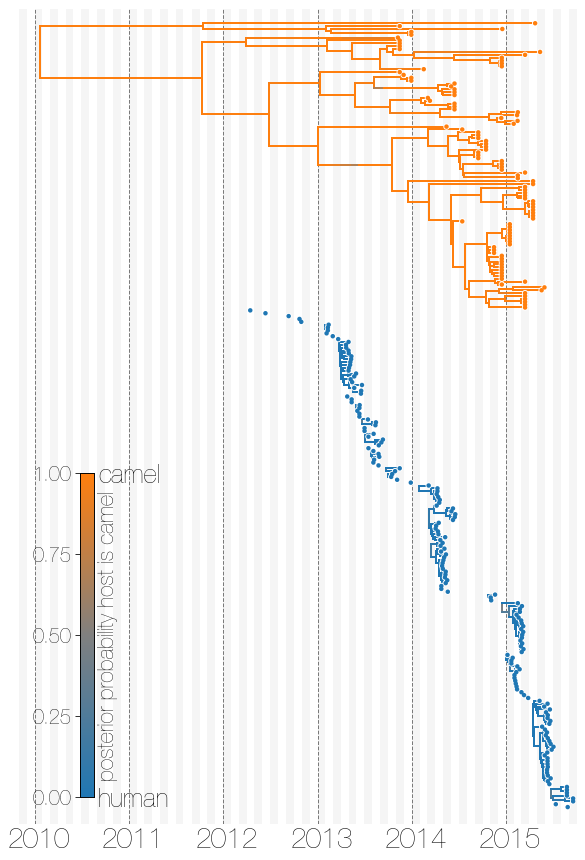

In [4]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')
cumulativeY=0
branchWidth=2
for t in subtrees.keys():
    #print t,len(subtrees[t])
    
    for st in subtrees[t]:
        #print st.singleType()
        #print st.toString()
        #print len([q for q in st.Objects if q.branchType=='leaf']),
        for k in st.Objects:
            c='k'
            if 'c' in k.traits['type.set']:
                hidx=k.traits['type.set'].index('c')
                c=host_cmap(k.traits['type.set.prob'][hidx])
            else:
                c=host_cmap(0.0)

            z=1
            if k.traits['type']=='h':
                z=2

            x=k.absoluteTime
            y=k.y+cumulativeY

            xp=k.parent.absoluteTime
            if xp==0:
                xp=x

            if k.branchType=='leaf':
                ax.scatter(x,y,s=20,facecolor=c,edgecolor='none',zorder=4)
                ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
            else:
                yl=k.children[0].y+cumulativeY
                yr=k.children[-1].y+cumulativeY
                ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)

            if st.Objects.index(k)!=0:
                ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)
        cumulativeY+=st.ySpan

every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2009,2016) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=28,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2000,2020)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2009-11-01'),bt.decimalDate('2015-10-01'))
ax.set_ylim(-5,tree12.ySpan+5)

ax2 = fig.add_axes([0.21, 0.15, 0.02, 0.3])
mpl.colorbar.ColorbarBase(ax2, cmap=host_cmap,ticks=np.linspace(0.0,1.0,5))
ax2.tick_params(size=5,labelsize=20)
ax2.set_ylabel('posterior probability host is camel')
ax3=ax2.twinx()
ax3.set_ylim(0,1)
ax3.set_yticks([0.0,1.0])
ax3.set_yticklabels(['human','camel'])
ax3.tick_params(size=0,labelsize=26)
plt.savefig('./../figures/mers_exploded.png',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
zipfile = ZipFile('./../data/phylo/skygrid.zip')

burnin=300000000

fnames=['stationary_%d/Saudi_camel_skygrid_oldMix.combined.log'%(x) for x in range(1,3)]
skygrid={x:{} for x in fnames}
for fname in fnames:
    for line in zipfile.open(fname).readlines():
        l=line.strip().split('\t')
        if '#' in line:
            pass
        elif l[0]=='state':
            header=l
            indices={x:i for i,x in enumerate(header) if 'skygrid.logPopSize' in x}
            cutoffIndex=header.index('skygrid.cutOff')
            for x in indices:
                if skygrid[fname].has_key(x)==False:
                    skygrid[fname][x]=[]
        elif int(l[0])>burnin:
            for x in indices:
                skygrid[fname][x].append(np.e**float(l[indices[x]]))
            skygridCutoff=float(l[cutoffIndex])

['Saudi_camel_skygrid.xml', '__MACOSX/', '__MACOSX/._Saudi_camel_skygrid.xml', 'stationary_1/', 'stationary_1/.DS_Store', '__MACOSX/stationary_1/', '__MACOSX/stationary_1/._.DS_Store', 'stationary_1/Saudi_camel_skygrid_oldMix.combined.log', 'stationary_1/Saudi_camel_skygrid_oldMix.combined.mcc.tree', 'stationary_2/', 'stationary_2/.DS_Store', '__MACOSX/stationary_2/', '__MACOSX/stationary_2/._.DS_Store', 'stationary_2/Saudi_camel_skygrid_oldMix.combined.log', 'stationary_2/Saudi_camel_skygrid_oldMix.combined.mcc.tree']


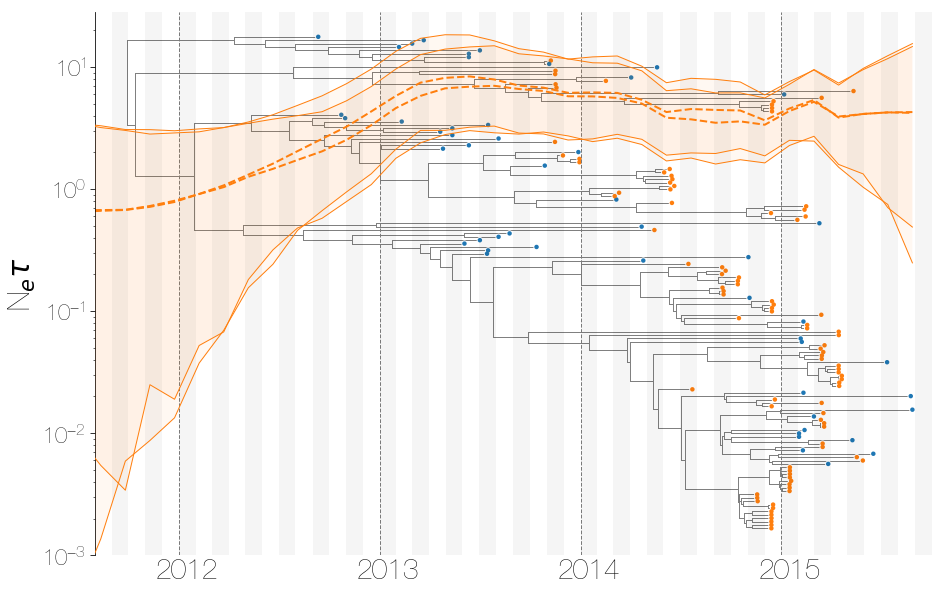

In [73]:
fig,ax = plt.subplots(figsize=(15,10),facecolor='w')

sorted_gridpoints={fname:sorted(skygrid[fname].keys(),key=lambda w:-int(w.split('Size')[-1])) for fname in skygrid.keys()}
# print sorted_gridpoints
skygrid_ysm={fname:[np.median(skygrid[fname][x]) for x in sorted_gridpoints[fname]] for fname in skygrid.keys()}
skygrid_hpds={fname:[hpd(skygrid[fname][x],0.95) for x in sorted_gridpoints[fname]] for fname in skygrid.keys()}
skygrid_los={fname:[x[0] for x in skygrid_hpds[fname]] for fname in skygrid.keys()}
skygrid_his={fname:[x[1] for x in skygrid_hpds[fname]] for fname in skygrid.keys()}

hi=max([max(skygrid_his[fname]) for fname in skygrid_his.keys()])
lo=max([min(skygrid_los[fname]) for fname in skygrid_los.keys()])

camel_tree=bt.loadNexus(zipfile.open('stationary_2/Saudi_camel_skygrid_oldMix.combined.mcc.tree').readlines())

branchWidth=1
ax2=ax.twinx()
for k in camel_tree.Objects:
    c='grey'
    #c=cmap(1.0)
    
    z=1
    
    mod=1/float(camel_tree.ySpan)*(hi-lo-0.5)
    
    x=k.absoluteTime
    y=lo+k.y*mod

    xp=k.parent.absoluteTime
    if xp==0:
        xp=x

    if k.branchType=='leaf':
        if 'camel' in k.name:
            c=host_cmap(1.0)
        elif 'human' in k.name:
            c=host_cmap(0.0)
        ax2.scatter(x,y,s=20,facecolor=c,edgecolor='none',zorder=4)
        ax2.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)
    else:
        yl=lo+k.children[0].y*mod
        yr=lo+k.children[-1].y*mod
        ax2.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z)
    c='grey'
    ax2.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z)

    
every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2009,2016) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=28,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2000,2020)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=5,direction='out')
ax2.tick_params(size=0)
ax2.set_yticklabels([])

ax.set_ylabel(r'N$_{e}\tau$',size=30)
#ax.set_xticklabels([])
# ax.set_yticklabels([])

    
ax.set_xlim(bt.decimalDate('2011-08-01'),bt.decimalDate('2015-10-01'))
ax.set_ylim(1e-3,hi+10.0)

mostRecentTip=max([k.absoluteTime for k in camel_tree.Objects])
skygrid_xs=np.linspace(mostRecentTip-skygridCutoff,mostRecentTip,len(indices))


fc=host_cmap(1.0)
ec='none'

for fname in skygrid.keys():
    ax.plot(skygrid_xs,skygrid_ysm[fname],color=fc,ls='--',lw=2)

    #ax.scatter(caseDates,[0.0]*len(caseDates),alpha=0.2,s=200,marker='|',lw=3,facecolor='k',zorder=100)
    ax.fill_between(skygrid_xs,skygrid_los[fname],skygrid_his[fname],alpha=0.05,facecolor=fc,edgecolor=ec,zorder=1000)
    ax.plot(skygrid_xs,skygrid_his[fname],color=fc,lw=1,zorder=1000)
    ax.plot(skygrid_xs,skygrid_los[fname],color=fc,lw=1,zorder=1000)

ax.set_yscale('log')

ax.set_zorder(ax2.get_zorder()+1000)
ax.patch.set_visible(False)
#plt.savefig('./../figures/mers_skygrid.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
zipfile = ZipFile('./../data/phylo/structured-coalescent-2fragments.zip')
trees={}

for tree_name in ['structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS%s_1,2.mcc.tree'%(x) for x in range(1,3)]:
    f=lambda x:x<0.1
    tr=bt.loadNexus(zipfile.open(tree_name).readlines()).collapseBranches(trait='posterior',f=f)
    
    keep=[k for k in tr.Objects if k.branchType=='leaf' and 'human' in k.name]
#     keep=[k for k in tr.Objects if k.branchType=='leaf' and 'camel' in k.name]
    tr=tr.reduceTree(keep)
    #tr.singleType()
    tr.treeStats()
    trees[tree_name]=tr


Tree height: 5.625331
Tree length: 53.304658
multitype tree
annotations present

Numbers of objects in tree: 339 (165 nodes and 174 leaves)


Tree height: 5.433245
Tree length: 54.414113
multitype tree
annotations present

Numbers of objects in tree: 320 (146 nodes and 174 leaves)



In [20]:
tree_names=sorted(trees.keys())
tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y)

cmap=mpl.cm.Spectral

for X in range(10):
    print 'untangling iteration %d'%(X+1)
    for t,tr in enumerate(tree_names):
        print tr
        ptr=tree_names[t-1]
        ntr=tree_names[t]
        seg=trees[ptr]
        nex_seg=trees[ntr]
        perms=[]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height):
            if k.branchType=='node':
                leaves=[[nex_seg.tipMap[tip] for tip in w.leaves] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                for c in range(len(leaves)):
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1])
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl]) for cl in leaves] ## extract y positions of descendents
                merge_ys=[i for s in ys for i in s]
                ypos=range(min(merge_ys),max(merge_ys)+1)
                
                order={i:x for i,x in enumerate(leaves)}
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(len(order[x])) if tip_positions[ptr].has_key(order[x][w])]))
                
                if new_order!=range(len(leaves)):
                    #print '\nnew:',new_order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects:
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions

untangling iteration 1
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree
untangling iteration 2
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree
untangling iteration 3
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree
untangling iteration 4
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree
untangling iteration 5
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree
untangling iteration 6
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree
structured-coalescent-2fragments/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tre

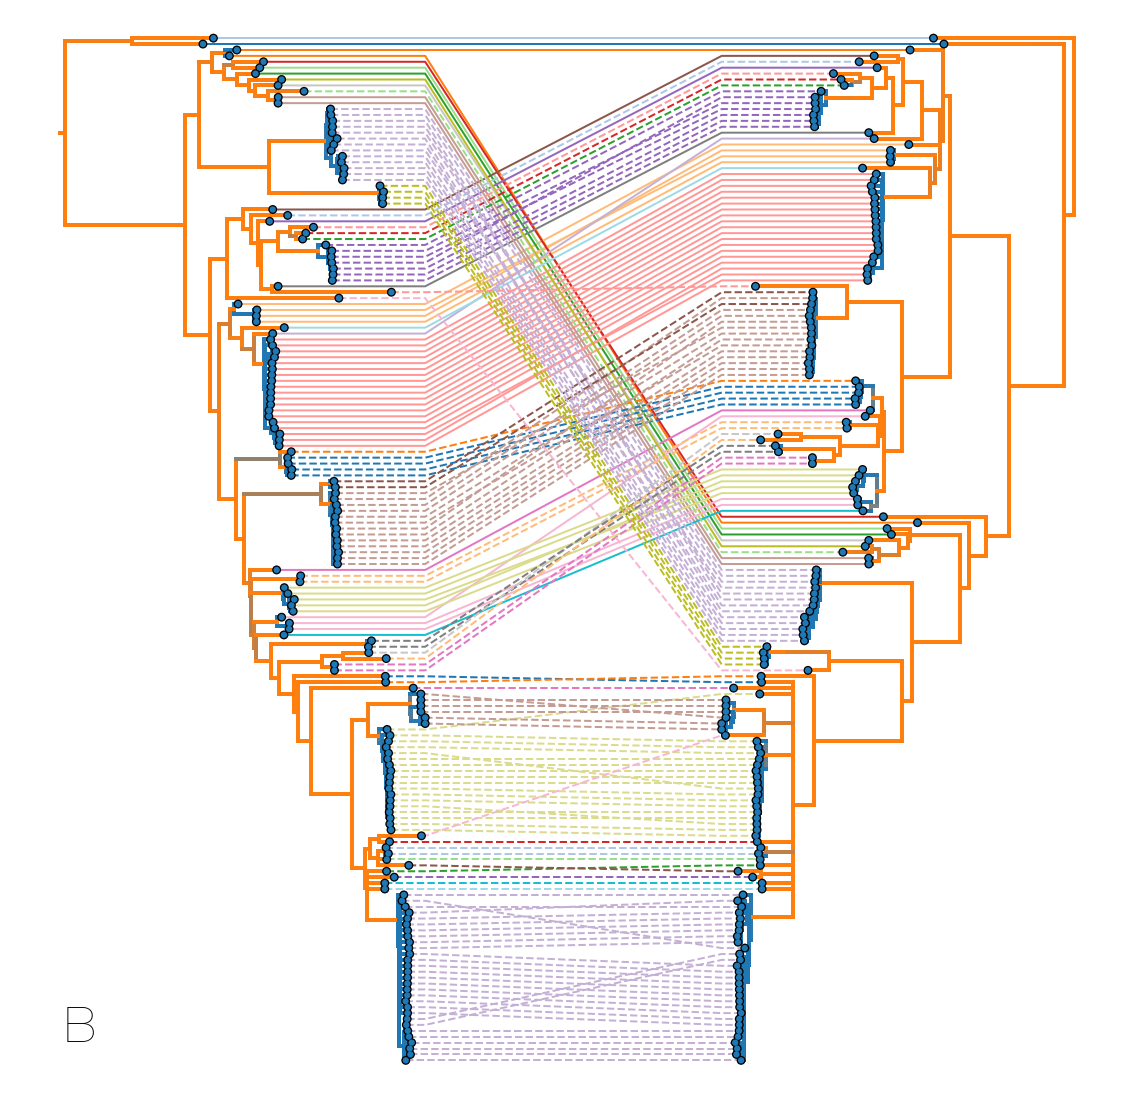

In [21]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='type' ## choose a trait to colour branches by

branchWidth=4 ## increase branch width, since trees will be smaller

colours={'c':mpl.cm.Reds,'h':mpl.cm.Blues}
tip_host={'c':[],'h':[]}

tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

types=['h','c']
labels=['a','b','c']
norm=mpl.colors.Normalize(0.0,1.2)

for tr in tree_names: ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in sorted(cur_tree.Objects,key=lambda w:w.y): ## iterate over branches
        if isinstance(k,bt.leaf): ## only interested in leaves
            tip_positions[tr][k.name]=(k.height,k.y) ## remember tree, tip's position
            host='h'
            if 'camel' in k.name:
                host='c'
            
            if k.name not in tip_host[host]:
                tip_host[host].append(k.name)

chainSpace=10
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    M=(0.5-t)*2
    
    if t==0:
        clade_id={}
        counter=0
        for k in cur_tree.Objects:
            if k.parent.traits.has_key(traitName) and k.traits[traitName]!=k.parent.traits[traitName]:
                if k.branchType=='node':
                    for w in k.leaves:
                        clade_id[cur_tree.tipMap[w]]=counter
                else:
                    clade_id[k.name]=counter
                counter+=1
    
    for k in cur_tree.Objects: ## iterate over branches
        x=M*k.height ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=M*k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent

        bc='k'
        if 'c' in k.traits['type.set']:
            hidx=k.traits['type.set'].index('c')
            bc=host_cmap(k.traits['type.set.prob'][hidx])
        else:
            bc=host_cmap(0.0)
            
        if isinstance(k,bt.leaf): ## if leaf...
            s=40 ## tip size can be fixed
            pos_in_first_tree=tip_positions[tree_names[-1]][k.name][1] ## fetch y coordinate of same tip in the first tree
            #frac_pos=pos_in_first_tree/float(cur_tree.ySpan) ## normalize coordinate to be within interval [0.0,1.0]
            ls='-'
            if clade_id[k.name]/20>0:
                ls='--'
            elif clade_id[k.name]/20>1:
                ls='-.'
                
            frac_pos=clade_id[k.name]%20/20.0
            
#             print frac_pos
            if k.traits['type']=='h':
                cmap=mpl.cm.Vega20
                c=cmap(frac_pos)
            else:
                c='grey'
                
            ax.scatter(x,y,s=s,facecolor=bc,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                if tip_positions[tree_names[t+1]].has_key(k.name):
                    next_x,next_y=tip_positions[tree_names[t+1]][k.name]
                    next_x=next_x*(0.5-(t+1))*2
                    next_x+=cumulative_displace+cur_tree.treeHeight+chainSpace

                    ax.plot([x,cumulative_displace+cur_tree.treeHeight,
                             cumulative_displace+cur_tree.treeHeight+chainSpace-trees[tree_names[t+1]].treeHeight,next_x],
                            [y,y,next_y,next_y],
                            lw=2,ls=ls,color=c,zorder=0) ## connect current tip with same tip in the next tree
            
        elif isinstance(k,bt.node): ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=bc,ls='-',zorder=9) ## plot vertical bar
        if k.parent.traits.has_key('type') and k.traits['type']!=k.parent.traits['type']:
            ax.plot([xp,x],[y,y],lw=branchWidth,color=host_cmap(1.0),ls='-',zorder=9)#mpl.cm.Vega10(1)
        else:
            ax.plot([xp,x],[y,y],lw=branchWidth,color=bc,ls='-',zorder=9) ## always plot branch
        
    cumulative_displace+=cur_tree.treeHeight+chainSpace ## increment displacement by the height of the tree

ax.set_ylim(-5,cur_tree.ySpan+5) ## set y limits

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.text(0.05,0.05,'B',size=50,transform=ax.transAxes)

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('./../figures/mers_chain.png',dpi=200,bbox_inches='tight')
plt.show()

In [91]:
clade_id={}

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    prev_tree=trees[tree_names[t-1]]
    
    size_distribution=[]
    
    counter=0
    
    for k in cur_tree.Objects:
        if k.parent.traits.has_key(traitName) and k.traits[traitName]!=k.parent.traits[traitName]:
            #print k.traits[traitName]
            if k.branchType=='node':
                for member in k.leaves:
                    clade_id[member]=counter
            
                size_distribution.append(len(k.leaves))
            else:
                clade_id[k.numName]=counter
                size_distribution.append(1)
                
            counter+=1
    print len(set(clade_id.values()))
            
    mismatch=0
    for k in prev_tree.Objects:
        if k.parent.traits.has_key(traitName) and k.traits[traitName]!=k.parent.traits[traitName]:
            if k.branchType=='node':
                composition=[clade_id[member] for member in k.leaves]
                if len(set(composition))>1:
                    mismatch+=1
                    print 'mixed clade composition: %s'%(composition)
                    
    print tr,tree_names[t-1],mismatch
    print 'Distribution of human clade sizes: %s'%(sorted(size_distribution,reverse=True))

54
mixed clade composition: [17, 17, 17, 13, 13, 17, 18, 17]
mixed clade composition: [20, 12, 20, 22, 20, 20]
mixed clade composition: [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30]
mixed clade composition: [45, 41]
/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/frag/MERS_274_2frag_sCoal.CDS1_1,2.mcc.tree /Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/frag/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree 4
Distribution of human clade sizes: [29, 19, 18, 13, 13, 7, 6, 5, 4, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
53
mixed clade composition: [3, 2]
mixed clade composition: [4, 5, 5, 5]
mixed clade composition: [11, 11, 19]
mixed clade composition: [44, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]
mixed clade composition: [41, 36]
/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/frag/MERS_274_2frag_sCoal.CDS2_1,2.mcc.tree /Users/evogytis/Docum

In [12]:
## outputs camel sequences and oldest sequence from each human cluster
clustID=1
clades={}

mostly_camel=open('./../data/phylo/camel_like.fasta','w')

for k in sorted(tree12.Objects,key = lambda x:-x.parent.height):
    if k.parent.traits.has_key('type') and k.parent.traits['type']!=k.traits['type']:
        if k.branchType=='node':
            clades['cluster%02d'%(clustID)]=k.leaves
            oldest=sorted([tree12.tipMap[w] for w in k.leaves],key=lambda q:ds[q])[0]
            print>>mostly_camel,'>%s\n%s'%(oldest,seqs[oldest])
        else:
            clades['cluster%02d'%(clustID)]=[k.numName]
            print>>mostly_camel,'>%s\n%s'%(k.name,seqs[k.name])
            
        clustID+=1
    elif k.branchType=='leaf' and k.traits['type']=='c':
        print>>mostly_camel,'>%s\n%s'%(k.name,seqs[k.name])

mostly_camel.close()
print clades

{'cluster22': ['176'], 'cluster25': ['122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '182', '183', '186', '221', '59'], 'cluster24': ['51'], 'cluster27': ['215', '53', '55', '56'], 'cluster50': ['219'], 'cluster51': ['172'], 'cluster52': ['44'], 'cluster53': ['119'], 'cluster10': ['166'], 'cluster11': ['120', '121', '188', '189', '190', '191'], 'cluster12': ['198', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246'], 'cluster13': ['167'], 'cluster14': ['192', '193', '194', '195'], 'cluster15': ['249'], 'cluster16': ['168'], 'cluster17': ['196'], 'cluster18': ['180', '181'], 'cluster19': ['113', '114', '115', '116', '117', '118', '171', '50', '62', '63', '64', '65', '66'], 'cluster30': ['170', '213', '214', '218', '228'], 'cluster31': ['220'], 'cluster36': ['262'], 'cluster37': ['264'], 'cluster34': ['261', '263'], 'cluster35': ['226'], 'cluster33': ['52'], 'cluster38': ['10', '11', '12', '13', '14'

In [16]:
# camel_path='/Users/evogytis/Documents/MERS_2.0/clean/data/alignments/camel_like/Saudi_camel_like.fasta'
camel_path='sequences/camel_like/Saudi_camel_like.fasta'
zipfile = ZipFile('./../data/phylo/sequences.zip')
# print zipfile.namelist()
L=29364

multiple=3*L/30+1

fragmented={i:{} for i,x in enumerate(range(0,L,multiple))}

for line in zipfile.open(camel_path).readlines():
    l=line.strip('\n')
    if '>' in l:
        name=l[1:]
    else:
        for I,i in enumerate(range(0,L,multiple)):
            fragmented[I][name]=l[i:i+multiple]
            
for i in fragmented.keys():
    out=open('./../data/phylo/MERS_skygridFrag_%d.fasta'%(i+1),'w')
    
    for strain in fragmented[i].keys():
        print>>out,'>%s\n%s'%(strain,fragmented[i][strain])
        
    out.close()

In [18]:
zipfile = ZipFile('./../data/phylo/frag_skygrid.zip')
burnin=20000000

fnames=['frag_skygrid/run%d/MERS_camelSkygrid.log'%(x) for x in range(1,6)]

frag_skygrid={'frag':{}}
for fname in fnames:
    for line in zipfile.open(fname).readlines():
        l=line.strip().split('\t')
        if '#' in line:
            pass
        elif l[0]=='state':
            header=l
            indices={x:i for i,x in enumerate(header) if 'skygrid.logPopSize' in x}
            cutoffIndex=header.index('skygrid.cutOff')
            for x in indices:
                if frag_skygrid['frag'].has_key(x)==False:
                    frag_skygrid['frag'][x]=[]
        elif int(l[0])>burnin:
            for x in indices:
                frag_skygrid['frag'][x].append(np.e**float(l[indices[x]]))
#                 skygrid[x].append(float(l[indices[x]]))
            skygridCutoff=float(l[cutoffIndex])

In [4]:

sorted_gridpoints={fname:sorted(skygrid[fname].keys(),key=lambda w:-int(w.split('Size')[-1])) for fname in skygrid.keys()}
# print sorted_gridpoints
skygrid_ysm={fname:[np.median(skygrid[fname][x]) for x in sorted_gridpoints[fname]] for fname in skygrid.keys()}
skygrid_hpds={fname:[hpd(skygrid[fname][x],0.95) for x in sorted_gridpoints[fname]] for fname in skygrid.keys()}
skygrid_los={fname:[x[0] for x in skygrid_hpds[fname]] for fname in skygrid.keys()}
skygrid_his={fname:[x[1] for x in skygrid_hpds[fname]] for fname in skygrid.keys()}

hi=max([max(skygrid_his[fname]) for fname in skygrid_his.keys()])
lo=max([min(skygrid_los[fname]) for fname in skygrid_los.keys()])


frag_sorted_gridpoints={fname:sorted(frag_skygrid[fname].keys(),key=lambda w:-int(w.split('Size')[-1])) for fname in frag_skygrid.keys()}
# print sorted_gridpoints
frag_skygrid_ysm={fname:[np.median(frag_skygrid[fname][x]) for x in frag_sorted_gridpoints[fname]] for fname in frag_skygrid.keys()}
frag_skygrid_hpds={fname:[hpd(frag_skygrid[fname][x],0.95) for x in frag_sorted_gridpoints[fname]] for fname in frag_skygrid.keys()}
frag_skygrid_los={fname:[x[0] for x in frag_skygrid_hpds[fname]] for fname in frag_skygrid.keys()}
frag_skygrid_his={fname:[x[1] for x in frag_skygrid_hpds[fname]] for fname in frag_skygrid.keys()}

frag_hi=max([max(frag_skygrid_his[fname]) for fname in frag_skygrid_his.keys()])
frag_lo=max([min(frag_skygrid_los[fname]) for fname in frag_skygrid_los.keys()])



SpearmanrResult(correlation=0.85517406962785103, pvalue=2.6632382282602365e-15)
4001 4001


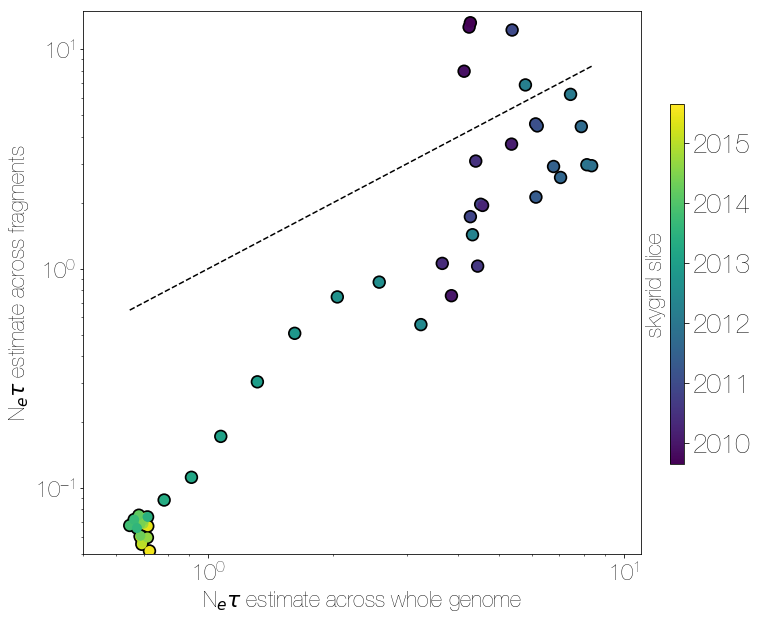

In [85]:
from scipy.stats import spearmanr

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

xs=[]
ys=[]
Xs=[]
Ys=[]
cmap=mpl.cm.viridis
norm=mpl.colors.Normalize(min(skygrid_xs),max(skygrid_xs))
for x in sorted_gridpoints[skygrid.keys()[0]]:
    ys=list(np.random.choice(frag_skygrid[frag_skygrid.keys()[0]][x],replace=False,size=len(skygrid[skygrid.keys()[0]][x])))
    xs=skygrid[skygrid.keys()[0]][x]
    t=skygrid_xs[int(x.split('Size')[-1])-1]
    
    ax.scatter(np.median(xs),np.median(ys),s=100,facecolor=cmap(norm(t)),edgecolor='none',zorder=20)
    ax.scatter(np.median(xs),np.median(ys),s=180,facecolor='k',edgecolor='none',zorder=19)
    Xs.append(np.median(xs))
    Ys.append(np.median(ys))
    
print spearmanr(Xs,Ys)
print len(xs),len(ys)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.5,11)
ax.set_ylim(0.05,15)

ax.plot(sorted(Xs),sorted(Xs),ls='--',color='k')
ax.set_ylabel(r'N$_{e}\tau$ estimate across fragments')
ax.set_xlabel(r'N$_{e}\tau$ estimate across whole genome')

ax2 = fig.add_axes([0.94, 0.25, 0.02, 0.5])
mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
ax2.tick_params(size=5,labelsize=26)
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('skygrid slice')

plt.savefig('./../figures/mers_skygrid_comparison.png',dpi=300,bbox_inches='tight')
plt.show()

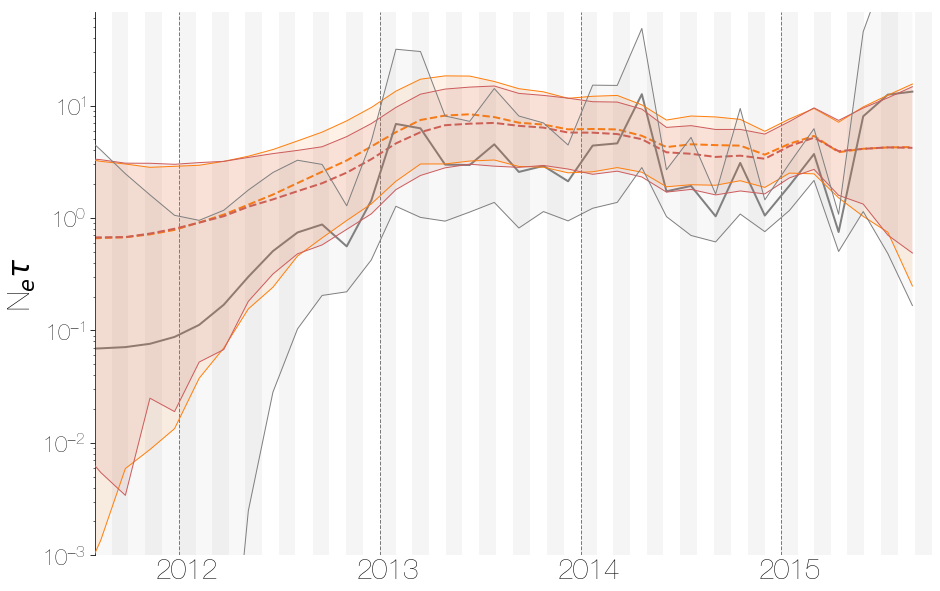

In [100]:
fig,ax = plt.subplots(figsize=(15,10),facecolor='w')
    
every=12
xDates=['%04d-%02d-01'%(y,m) for y in range(2009,2016) for m in range(1,13)]

[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=28,size=0)

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2000,2020)]

        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=5,direction='out')
ax2.tick_params(size=0)
ax2.set_yticklabels([])

ax.set_ylabel(r'N$_{e}\tau$',size=30)
#ax.set_xticklabels([])
# ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2011-08-01'),bt.decimalDate('2015-10-01'))
ax.set_ylim(1e-3,hi+50.0)

mostRecentTip=max([k.absoluteTime for k in camel_tree.Objects])
skygrid_xs=np.linspace(mostRecentTip-skygridCutoff,mostRecentTip,len(indices))

ec='none'

for f,fname in enumerate(skygrid.keys()):
    fc=host_cmap(1.0)
    if f==1:
        fc='indianred'
    ax.plot(skygrid_xs,skygrid_ysm[fname],color=fc,ls='--',lw=2)

    #ax.scatter(caseDates,[0.0]*len(caseDates),alpha=0.2,s=200,marker='|',lw=3,facecolor='k',zorder=100)
    ax.fill_between(skygrid_xs,skygrid_los[fname],skygrid_his[fname],alpha=0.1,facecolor=fc,edgecolor=ec,zorder=1000)
    ax.plot(skygrid_xs,skygrid_his[fname],color=fc,lw=1,zorder=1000)
    ax.plot(skygrid_xs,skygrid_los[fname],color=fc,lw=1,zorder=1000)

    
for fname in frag_skygrid.keys():
    fc='grey'
    ax.plot(skygrid_xs,frag_skygrid_ysm[fname],color=fc,ls='-',lw=2)

    #ax.scatter(caseDates,[0.0]*len(caseDates),alpha=0.2,s=200,marker='|',lw=3,facecolor='k',zorder=100)
    ax.fill_between(skygrid_xs,frag_skygrid_los[fname],frag_skygrid_his[fname],alpha=0.05,facecolor=fc,edgecolor=ec,zorder=1000)
    ax.plot(skygrid_xs,frag_skygrid_his[fname],color=fc,lw=1,zorder=1000)
    ax.plot(skygrid_xs,frag_skygrid_los[fname],color=fc,lw=1,zorder=1000)

    
ax.set_yscale('log')

ax.set_zorder(ax2.get_zorder()+1000)
ax.patch.set_visible(False)
plt.savefig('./../figures/mers_skygrid.png',dpi=300,bbox_inches='tight')
plt.show()